# Predicting Wine Quality From Reviews
## Olivia Wang
#### Packages: sklearn, matplotlib, seaborn, pandas, numpy, mglearn
#### Source: https://www.kaggle.com/zynicide/wine-reviews

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import mglearn

#Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
#Models
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
wines = pd.read_csv('winemag-data_first150k.csv')
wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


Only keeping wine information in the US

In [4]:
wines = wines[wines.country == 'US']
wines = wines.drop(columns = 'Unnamed: 0')

# Bag of Words and simple Features

### 1.1 Create a baseline model for predicting wine quality using only non-text features.

I would like to predict `points` for wines, as a result, I will use `points` as our target.

In [5]:
# Drop text features
wines_nt = wines.drop(columns = 'description')

In [6]:
wines_nt.isnull().sum()

country            0
designation    22052
points             0
price            258
province           0
region_1         136
region_2        1444
variety            0
winery             0
dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

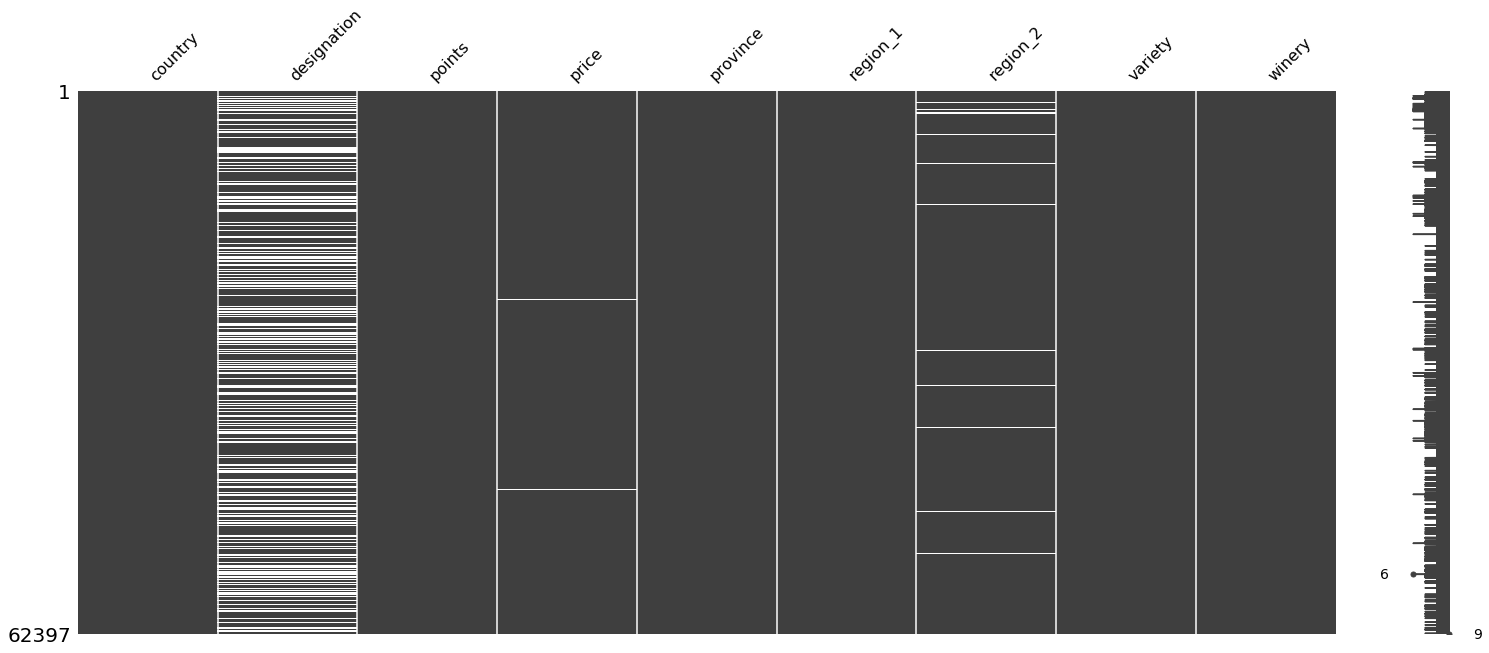

In [7]:
msno.matrix(wines_nt)
plt.show

In [8]:
wines_nt.nunique(axis = 0)

country            1
designation    11241
points            21
price            149
province          24
region_1         265
region_2          18
variety          218
winery          4761
dtype: int64

We can see that columns `designation` and `winery` has a large number of unique data. As a result, I will be using `target encoding` for these two columns.

In [9]:
wines_nt = wines_nt.sample(frac=0.2, replace=False, random_state=1)
# Remove target column
wines_nt_target = wines_nt.points
wines_nt = wines_nt.drop('points', axis = 1)

In [10]:
categorical = []
continuous = []
target_cat = []
for column in wines_nt.columns:
    if column == 'designation' or column =='winery':
        target_cat.append(column)
    elif wines_nt[column].dtype == 'object':
        categorical.append(column)
    else:
        continuous.append(column)

In [11]:
print(f'categorical variables (one-hot-encoding): {categorical}')
print(f'categorical variables (target-encoding): {target_cat}')
print(f'continuous variables: {continuous}')

categorical variables (one-hot-encoding): ['country', 'province', 'region_1', 'region_2', 'variety']
categorical variables (target-encoding): ['designation', 'winery']
continuous variables: ['price']


In [12]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

cat_target_transformer = make_pipeline(
    TargetEncoder())

preprocessor = make_column_transformer(
        (numeric_transformer, continuous),
        (categorical_transformer, categorical),
        (cat_target_transformer, target_cat)
        )

In [13]:
rr = make_pipeline(preprocessor,Ridge())

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    wines_nt, wines_nt_target, test_size = 0.20, random_state=0)

In [15]:
scores = np.mean(cross_val_score(rr,X_train,y_train, scoring='r2'))
print(f'Baseline Ridge Regression Score using Non-Text Features: {scores:0.8f}')

Baseline Ridge Regression Score using Non-Text Features: 0.39071614


### 1.2 Create a simple text-based model using a bag-of-words approach and a linear model.

In [17]:
wines= wines.sample(frac=0.2, replace=False, random_state=1)

In [18]:
X = wines['description']
y = wines['points']

In [19]:
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<9983x10299 sparse matrix of type '<class 'numpy.int64'>'
	with 344842 stored elements in Compressed Sparse Row format>


In [20]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 10299
First 20 features:
['00', '000', '01', '02', '02s', '03', '03s', '04', '05', '05s', '06', '064', '07', '07s', '08', '09', '09s', '10', '100', '1000']
Features 20010 to 20030:
[]
Every 2000th feature:
['00', 'combined', 'gingerbread', 'naked', 'sensitive', 'watered']


In [21]:
scores = cross_val_score(Ridge(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.64


In [22]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(Ridge(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.72
Best parameters:  {'alpha': 10}


### 1.3 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. 

### Rescaling with TfidfVectorizer

In [23]:
tf = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     Ridge())
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(tf, param_grid, cv=5)
grid.fit(text_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                                               

In [24]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.67
Best parameters:  {'ridge__alpha': 100}


In [25]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

In [26]:
# transform the training dataset:
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over dataset:
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

In [27]:
print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['bodied' 'blackberries' 'price' 'raspberries' 'jammy' 'jam' 'flavors'
 'give' 'mocha' 'finishes' 'taste' 'could' 'drinking' 'minerality'
 'forward' 'hints' 'wrapped' 'pleasant' 'sandalwood' 'elegance']
Features with highest tfidf: 
['reductive' 'shiraz' 'betz' 'vintners' 'olive' 'as' 'cab' 'fenestra'
 'ross' 'liquorous' 'phase' 'santa' 'label' 'sappy' 'world' 'so' '50'
 'then' 'banana' 'walla']


In [28]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['and' 'the' 'of' 'with' 'this' 'flavors' 'it' 'is' 'in' 'wine' 'to'
 'fruit' 'but' 'that' 'dry' 'cherry' 'for' 'tannins' 'oak' 'acidity'
 'finish' 'from' 'on' 'now' 'sweet' 'has' 'ripe' 'rich' 'are' 'black' 'an'
 'drink' 'good' 'shows' 'its' 'blackberry' 'red' 'soft' 'vanilla' 'very'
 'palate' 'there' 'pinot' 'cabernet' 'cherries' 'like' 'blend' 'spice'
 'as' 'not' 'chocolate' 'notes' 'years' 'some' 'crisp' 'at' 'by' 'tannic'
 'aromas' 'more' 'pepper' 'full' 'well' 'into' 'raspberry' 'cola' 'you'
 'style' 'bit' 'bodied' 'vineyard' 'fine' 'sauvignon' 'tart' 'just' 'all'
 'little' 'spicy' 'or' 'be' 'complex' 'one' 'syrah' 'blackberries' 'new'
 'chardonnay' 'through' 'green' 'alcohol' 'citrus' 'smoky' 'light' 'dark'
 'balanced' 'up' 'currant' 'clean' 'merlot' 'made' 'texture']


#### Model Coefficients

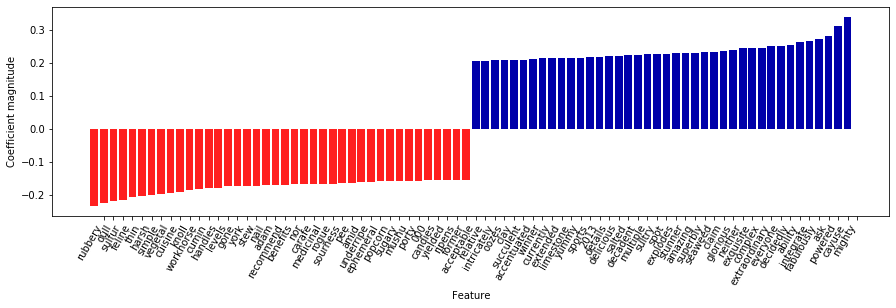

In [29]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["ridge"].coef_,
    feature_names, n_top_features=40)

### Rescaling with N-grams

In [30]:
ng = make_pipeline(TfidfVectorizer(min_df=5), Ridge())
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(ng, param_grid, cv=5)
grid.fit(text_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                                               

In [31]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.71
Best parameters:
{'ridge__alpha': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


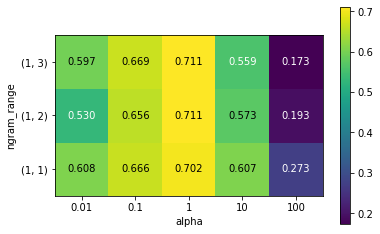

In [32]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="alpha", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['ridge__alpha'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

#### Model Coefficients

(-22, 22)

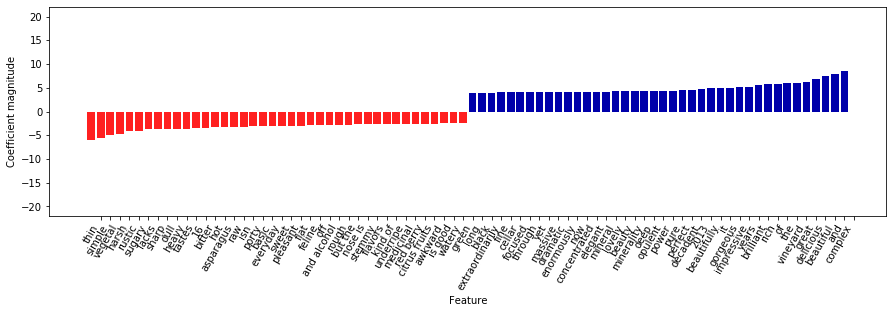

In [33]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['ridge'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

### Character n-grams Rescaling

In [20]:
char_vect = CountVectorizer(ngram_range=(1, 2), min_df=5, analyzer="char_wb")
char_pip = make_pipeline(char_vect, RidgeCV())
scores = cross_val_score(char_pip, text_train, y_train, scoring = 'r2')

In [21]:
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.62


### Test Score Using N-gram and TfidfVectorizer

In [36]:
scaling = CountVectorizer(ngram_range=(1, 2), min_df=5)
text_train_s = scaling.fit_transform(text_train)
text_test_s = scaling.transform(text_test)
rr = RidgeCV().fit(text_train_s, y_train)
score = rr.score(text_test_s, y_test)

In [38]:
print("Test Accuracy using N-gram and TfidfVectorizer: {:.5f}".format(score))

Test Accuracy using N-gram and TfidfVectorizer: 0.72036


### 1.4 Combine the non-text features and the text features. 

In [11]:
wines_c= wines.sample(frac=0.2, replace=False, random_state=1)
y = wines_c.points
X_c = wines_c.drop('points', axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

In [13]:
categorical = []
continuous = []
target_cat = []
text = ['description']
for column in X_c.columns:
    if column != 'description':
        if column == 'designation' or column =='winery':
            target_cat.append(column)
        elif X_c[column].dtype == 'object':
            categorical.append(column)
        else:
            continuous.append(column)

In [8]:
print(f'categorical variables (one-hot-encoding): {categorical}')
print(f'categorical variables (target-encoding): {target_cat}')
print(f'continuous variables: {continuous}')
print(f'text variables: {text}')

categorical variables (one-hot-encoding): ['country', 'province', 'region_1', 'region_2', 'variety']
categorical variables (target-encoding): ['designation', 'winery']
continuous variables: ['price']
text variables: ['description']


In [9]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

cat_target_transformer = make_pipeline(
    TargetEncoder())

preprocessor = make_column_transformer(
        (numeric_transformer, continuous),
        (categorical_transformer, categorical),
        (cat_target_transformer, target_cat),
        (CountVectorizer(), 'description'))

In [10]:
rr = make_pipeline(preprocessor,Ridge())

In [11]:
scores = np.mean(cross_val_score(rr, X_train, y_train, scoring='r2'))
print(f' Ridge Regression Score using Non-Text and Text Features: {scores:0.8f}')

 Ridge Regression Score using Non-Text and Text Features: 0.70894766


We can see that adding the `non-text` features to the `text` features improved our training accuracy from just using bag-of-words by about 0.04. 
In addition to which, it definitely improves our training accuracy from using just non-text features significantly by about 0.3.

# Word Vectors 

### Using a pretrained word-embedding (word2vec, glove or fasttext) for featurization instead of the bag-of-words model. 

In [5]:
import spacy
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner"])

#### Applying a Pretrained Word-Embedding (word2vec)  to Just the Text Feature `description`

In [6]:
#Subsambple
wines_t = wines.sample(frac=0.2, replace=False, random_state=1)

In [7]:
X = wines_t['description']
y = wines_t['points']
X_train_t, X_test_t, y_train, y_test = train_test_split(
    X, y, random_state=0)

In [8]:
docs_train = [nlp(d).vector for d in X_train_t]
X_train_t = np.vstack(docs_train)
X_train_t.shape

(9359, 300)

##### Training Score Using Word2vec and Just Text Feature: `Description`

In [9]:
lr_w2v = Ridge().fit(X_train_t, y_train)
lr_w2v.score(X_train_t, y_train)

0.6191651767670672

##### Just by looking at the `text feature`: `description`, we can see that using a pretrained word-embedding did not improve our model significantly as compared to just using CountVectorization.

### Combining Text and Non-Text Features

In [6]:
wines_w_b= wines.sample(frac=0.2, replace=False, random_state=1)
y = wines_w_b.points
X_w_b = wines_w_b.drop('points', axis = 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_w_b, y, test_size=0.2, random_state=42)

In [8]:
categorical = []
continuous = []
target_cat = []
text = ['description']
for column in X_w_b.columns:
    if column != 'description':
        if column == 'designation' or column =='winery':
            target_cat.append(column)
        elif X_w_b[column].dtype == 'object':
            categorical.append(column)
        else:
            continuous.append(column)

In [9]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

cat_target_transformer = make_pipeline(
    TargetEncoder())

# Just Word2vec 
X_w_b['description'] = np.vstack([nlp(d).vector for d in X_w_b['description']])

preprocessor = make_column_transformer(
        (numeric_transformer, continuous),
        (categorical_transformer, categorical),
        (cat_target_transformer, target_cat)
        )

In [10]:
# Word2Vec and Bag-of-Words
preprocessor2 =  make_column_transformer(
        (numeric_transformer, continuous),
        (categorical_transformer, categorical),
        (cat_target_transformer, target_cat),
        (CountVectorizer(), 'description')
        )

#### Ridge Regression Using Non-Text and Text Features ( Using only Word2Vec)

In [11]:
rr = make_pipeline(preprocessor,Ridge())

In [12]:
scores = np.mean(cross_val_score(rr, X_train, y_train, scoring='r2'))
print(f' Ridge Regression Score using Non-Text and Text Features (with Word2Vec) : {scores:0.8f}')

 Ridge Regression Score using Non-Text and Text Features (with Word2Vec) : 0.38471618


#### Ridge Regression Using Non-Text and Text Features (Using both Word2Vec and Bag-of-Words)

In [13]:
rr2 = make_pipeline(preprocessor2,Ridge())

In [14]:
scores = np.mean(cross_val_score(rr2, X_train, y_train, scoring='r2'))
print(f' Ridge Regression Score using Non-Text and Text Features (with Word2Vec and BoW) : {scores:0.8f}')

 Ridge Regression Score using Non-Text and Text Features (with Word2Vec and BoW) : 0.70894766


##### Combining both `Text` and `Non-Text` features, we can see that combing Word2Vec and Bag-of-Words yielded very similar training accuracy to when using just Bag-of-Words, giving us an accuracy of around `0.71`